# Data

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('../full_portfolio_analysis.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:

from backbone.utils.wfo_utils import run_strategy, run_wfo
from backbone.utils.general_purpose import calculate_units_size, diff_pips

import itertools
import numpy as np
import pandas as pd
import pandas_ta as pandas_ta
import MetaTrader5 as mt5
import MetaTrader5 as mt5
import pandas as pd
from backtest.get_data import get_data
import pytz
from datetime import datetime
from pandas import Timestamp
import numpy as np
import random
from backtesting import Strategy
from backtesting.lib import crossover
import talib as ta

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

random.seed(42)

In [3]:
INITIAL_CASH = 10_000
MARGIN = 1/30
COMMISSION = 7e-4

timezone = pytz.timezone("Etc/UTC")
date_from_get_data = datetime(2021, 10, 1, tzinfo=timezone)
date_to_get_data = datetime(2024, 9, 1, tzinfo=timezone)

#
limited_testing_start_date = Timestamp('2023-09-01 00:00:00', tz='UTC')
limited_testing_end_date = Timestamp('2024-09-01 00:00:00', tz='UTC')

In [4]:
groups = [
    'Forex',
    'Cash CFD',
    'Cash II CFD',
    'Metals CFD',
    'Crypto CFD',
    'Exotics',
    'Equities I CFD',
    'Equities II CFD',
    'Agriculture',
    'Commodities'
]

In [5]:
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

symbols = mt5.symbols_get()

tickers = [symbol.path.split('\\')[1] for symbol in symbols if (
    ('Agriculture' in symbol.path)
    or ('Cash CFD' in symbol.path)
    or ('Cash II CFD' in symbol.path)
    or ('Crypto CFD' in symbol.path)
    or ('Equities I CFD' in symbol.path)
    or ('Equities II CFD' in symbol.path)
    or ('Agriculture' in symbol.path)
    or ('Equities II CFD' in symbol.path)
    or ('Commodities' in symbol.path)
    # or ('Forex' in symbol.path)
    )
]


print(tickers)

intervals = [
    # mt5.TIMEFRAME_H8,
    mt5.TIMEFRAME_H6,
    mt5.TIMEFRAME_H4,
    mt5.TIMEFRAME_H3,
    mt5.TIMEFRAME_H2,
    mt5.TIMEFRAME_H1,
    # mt5.TIMEFRAME_M15,
]

symbols = get_data(tickers, intervals, date_from_get_data, date_to_get_data)

['GER40.cash', 'UK100.cash', 'US100.cash', 'US30.cash', 'US500.cash', 'AUS200.cash', 'EU50.cash', 'FRA40.cash', 'HK50.cash', 'JP225.cash', 'N25.cash', 'SPN35.cash', 'US2000.cash', 'UKOIL.cash', 'USOIL.cash', 'ADAUSD', 'BTCUSD', 'DASHUSD', 'DOGEUSD', 'DOTUSD', 'ETHUSD', 'LTCUSD', 'NEOUSD', 'XMRUSD', 'XRPUSD', 'AAPL', 'AMZN', 'BABA', 'BAC', 'GOOG', 'MSFT', 'NFLX', 'NVDA', 'PFE', 'RACE', 'T', 'TSLA', 'V', 'WMT', 'ZM', 'AIRF', 'ALVG', 'BAYGn', 'DBKGn', 'IBE', 'LVMH', 'VOWG_p', 'META', 'COCOA.c', 'COFFEE.c', 'CORN.c', 'SOYBEAN.c', 'WHEAT.c', 'NATGAS.cash']
MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
GER40.cash
GER40.cash
GER40.cash
GER40.cash
GER40.cash
UK100.cash
UK100.cash
UK100.cash
UK100.cash
UK100.cash
US100.cash
US100.cash
US100.cash
US100.cash
US100.cash
US30.cash
US30.cash
US30.cash
US30.cash
US30.cash
US500.cash
US500.cash
US500.cash
US500.cash
US500.cash
AUS200.cash
AUS200.cash
AUS200.cash
AUS200.cash
AUS200.cash
EU50.cash
EU50.cash
EU50.cas

In [6]:
max_start_date = None
intervals_start_dates = {}

tickers = np.unique(list(symbols.keys())).tolist()

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date


intervals_start_dates


print(intervals_start_dates)
print(limited_testing_start_date)
print(limited_testing_end_date)

{16390: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16388: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16387: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16386: Timestamp('2024-10-23 00:00:00+0000', tz='UTC'), 16385: Timestamp('2024-10-23 01:00:00+0000', tz='UTC')}
2023-09-01 00:00:00+00:00
2024-09-01 00:00:00+00:00


# Estrategia

In [7]:
from backbone.mean_reversion_strategy import MeanReversion

STRATEGY = MeanReversion

# Analisis preliminar

In [8]:
strategies = [
    STRATEGY
]

experiments = list(itertools.product(
    tickers, intervals, strategies
))

stats_per_symbol = {}

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:
    try:
        print(ticker, interval)
        
        if ticker not in stats_per_symbol.keys():
            stats_per_symbol[ticker] = {}
        
        prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

        df_stats, stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN
        )

        performance = pd.concat([performance, df_stats])
        stats_per_symbol[ticker][interval] = stats

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)

AAPL 16390
AAPL 16388
AAPL 16387
AAPL 16386
AAPL 16385
ADAUSD 16390
ADAUSD 16388
ADAUSD 16387
ADAUSD 16386
ADAUSD 16385
AIRF 16390
AIRF 16388
AIRF 16387
AIRF 16386
AIRF 16385
ALVG 16390
ALVG 16388
ALVG 16387
ALVG 16386
ALVG 16385
AMZN 16390
AMZN 16388
AMZN 16387
AMZN 16386
AMZN 16385
AUS200.cash 16390
AUS200.cash 16388
AUS200.cash 16387
AUS200.cash 16386
AUS200.cash 16385
BABA 16390
BABA 16388
BABA 16387
BABA 16386
BABA 16385
BAC 16390
BAC 16388
BAC 16387
BAC 16386
BAC 16385
BAYGn 16390
BAYGn 16388
BAYGn 16387
BAYGn 16386
BAYGn 16385
BTCUSD 16390
BTCUSD 16388
BTCUSD 16387
BTCUSD 16386
BTCUSD 16385
COCOA.c 16390
COCOA.c 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


COCOA.c 16387
COCOA.c 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


COCOA.c 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:90: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


COFFEE.c 16390
COFFEE.c 16388
COFFEE.c 16387
COFFEE.c 16386
COFFEE.c 16385
CORN.c 16390
CORN.c 16388
CORN.c 16387
CORN.c 16386
CORN.c 16385
DASHUSD 16390
DASHUSD 16388
DASHUSD 16387
DASHUSD 16386
DASHUSD 16385
DBKGn 16390
DBKGn 16388
DBKGn 16387
DBKGn 16386
DBKGn 16385
DOGEUSD 16390
DOGEUSD 16388
DOGEUSD 16387
DOGEUSD 16386
DOGEUSD 16385
DOTUSD 16390
DOTUSD 16388
DOTUSD 16387
DOTUSD 16386
DOTUSD 16385
ETHUSD 16390
ETHUSD 16388
ETHUSD 16387
ETHUSD 16386
ETHUSD 16385
EU50.cash 16390
EU50.cash 16388
EU50.cash 16387
EU50.cash 16386
EU50.cash 16385
FRA40.cash 16390
FRA40.cash 16388
FRA40.cash 16387
FRA40.cash 16386
FRA40.cash 16385
GER40.cash 16390
GER40.cash 16388
GER40.cash 16387
GER40.cash 16386
GER40.cash 16385
GOOG 16390
GOOG 16388
GOOG 16387
GOOG 16386
GOOG 16385
HK50.cash 16390
HK50.cash 16388
HK50.cash 16387
HK50.cash 16386
HK50.cash 16385
IBE 16390
IBE 16388
IBE 16387
IBE 16386
IBE 16385
JP225.cash 16390
JP225.cash 16388
JP225.cash 16387
JP225.cash 16386
JP225.cash 16385
LTCUSD 163

In [ ]:

filter_performance = performance[
    (performance['return/dd']>2)
    # & (performance['stability_ratio']>0.6)
].sort_values(by=['return/dd'], ascending=[False])#.drop_duplicates(subset=['ticker'], keep='first')

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()


In [22]:
filter_performance = performance[performance['ticker'].isin(portfolio)].sort_values(by=['ticker', 'interval'], ascending=[False, True])[
    [
        'strategy',
        'ticker',
        'interval',
        'stability_ratio',
        'trades',
        'return',
        'drawdown',
        'return/dd',
        'custom_metric'
        ]
]#.drop_duplicates(subset=['ticker'], keep='first')

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()

display(filter_performance)

pd.DataFrame(filter_performance.groupby(['ticker'])['return/dd'].mean())



,strategy,ticker,interval,stability_ratio,trades,return,drawdown,return/dd,custom_metric
0,MeanReversion,XMRUSD,16385,0.904167,400,45.787252,11.119298,4.117819,22.645456
0,MeanReversion,XMRUSD,16386,0.812206,216,23.151507,9.015113,2.568077,12.436478
0,MeanReversion,XMRUSD,16387,0.532271,165,7.165209,9.490862,0.754959,3.491463
0,MeanReversion,XMRUSD,16388,0.652856,116,11.683212,7.877618,1.483089,6.267164
0,MeanReversion,XMRUSD,16390,0.285746,76,3.622506,8.901178,0.406969,1.589251
0,MeanReversion,WHEAT.c,16385,0.339557,189,-3.511792,15.773459,-0.222639,-1.098548
0,MeanReversion,WHEAT.c,16386,0.377130,114,14.125948,14.541433,0.971427,4.312772
0,MeanReversion,WHEAT.c,16387,0.551621,95,20.675056,11.508263,1.796540,7.544465
0,MeanReversion,WHEAT.c,16388,0.645385,79,26.126539,7.282935,3.587364,13.822055
0,MeanReversion,WHEAT.c,16390,0.175244,57,5.786566,7.671073,0.754336,2.709702


,return/dd
ticker,
BAYGn,0.480429
CORN.c,2.011219
PFE,1.766933
UKOIL.cash,0.552073
WHEAT.c,1.377406
XMRUSD,1.866183


In [23]:

filter_performance = performance[
    (performance['ticker'] == 'XMRUSD')
    | (performance['ticker'] == 'PFE')
    | (performance['ticker'] == 'WHEAT.c')
    | (performance['ticker'] == 'CORN.c')
].sort_values(by=['return/dd'], ascending=[False])

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()

filter_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,MeanReversion,XMRUSD,16385,0.904167,45.787252,14578.725207,11.119298,105 days 15:00:00,55.500000,1.552584,400,0.195873,61.062051,14578.725207,365 days 23:00:00,4.117819,22.645456
0,MeanReversion,WHEAT.c,16388,0.645385,26.126539,12612.653913,7.282935,122 days 12:00:00,59.493671,2.049597,79,0.549069,61.290323,12612.653913,364 days 20:00:00,3.587364,13.822055
0,MeanReversion,CORN.c,16385,0.674677,26.320768,12632.076840,8.781405,130 days 05:00:00,48.760331,1.420383,121,0.140022,45.099703,12632.076840,364 days 18:00:00,2.997330,12.927133
0,MeanReversion,PFE,16387,0.765131,16.131533,11613.153276,5.666198,63 days 21:00:00,58.974359,1.706698,39,0.817322,56.191744,11613.153276,364 days 06:00:00,2.846977,8.926720
0,MeanReversion,CORN.c,16386,0.528558,20.785447,12078.544725,7.667985,162 days 04:00:00,52.000000,1.543385,75,0.245139,47.177419,12078.544725,364 days 18:00:00,2.710679,10.384909
0,MeanReversion,PFE,16386,0.761122,15.180448,11518.044829,5.713874,65 days 00:00:00,52.941176,1.420097,51,0.464881,57.200000,11518.044829,364 days 06:00:00,2.656770,8.933985
0,MeanReversion,XMRUSD,16386,0.812206,23.151507,12315.150652,9.015113,85 days 00:00:00,56.944444,1.312053,216,0.327583,64.535698,12315.150652,366 days 00:00:00,2.568077,12.436478
0,MeanReversion,CORN.c,16388,0.693512,12.886578,11288.657754,5.173906,122 days 04:00:00,51.785714,1.113272,56,0.271710,50.268817,11288.657754,364 days 20:00:00,2.490686,8.438919
0,MeanReversion,WHEAT.c,16387,0.551621,20.675056,12067.505618,11.508263,130 days 12:00:00,56.842105,1.514258,95,0.349709,62.988506,12067.505618,364 days 18:00:00,1.796540,7.544465
0,MeanReversion,PFE,16388,0.810702,5.806513,10580.651324,3.364732,71 days 00:00:00,54.545455,0.944565,22,0.650913,53.400000,10580.651324,364 days 04:00:00,1.725699,4.171227


In [ ]:
# for ticker, interval in zip(portfolio, intervals):
    
#     prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

#     df_stats = run_strategy(
#         strategy=strategy,
#         ticker=ticker,
#         interval=interval,
#         commission=COMMISSION, 
#         prices=prices, 
#         initial_cash=INITIAL_CASH, 
#         margin=MARGIN,
#         plot=True
#     )


# WFO

In [25]:
lookback_bars_per_interval = {
    15: 2000,
    16385: 2000,
    16386: 1800,
    16387: 1800,
    16388: 1200,
    16390: 1200,
    16392: 1200,
}

In [26]:
from backbone.utils.wfo_utils import optimization_function

validation_bars = 200
warmup_bars = 50

all_wfo_performances = pd.DataFrame()
all_opt_params = {}

params = {
    'deviation_threshold': list(np.arange(0.01, 0.2, 0.02).round(2)),
    'atr_multiplier' : [1.5, 1.8, 2, 2.5, 1.8, 3],
}

for index, row in filter_performance.iterrows():
    
    try:
        ticker = row.ticker
        interval = row.interval
        print(ticker, interval)
        
        lookback_bars = lookback_bars_per_interval[interval]
        
        prices = symbols[ticker][interval]

        wfo_stats, df_stats, opt_params = run_wfo(
            strategy=STRATEGY,
            ticker=ticker,
            interval=interval,
            prices=prices,
            initial_cash=INITIAL_CASH,
            commission=COMMISSION,
            margin=MARGIN,
            optim_func=optimization_function,
            params=params,
            lookback_bars=lookback_bars,
            warmup_bars=warmup_bars,
            validation_bars=validation_bars,
            plot=False
        )
                
        if ticker not in all_opt_params.keys():
            all_opt_params[ticker] = {}

        all_opt_params[ticker][interval] = opt_params

        all_wfo_performances = pd.concat([all_wfo_performances, df_stats])
    
    except Exception as e:
        print(f'No se pudo ejecutar para el ticker {ticker}: {e}')
    
all_wfo_performances['return/dd'] = all_wfo_performances['return'] / -all_wfo_performances['drawdown']
all_wfo_performances['drawdown'] = -all_wfo_performances['drawdown']
all_wfo_performances['custom_metric'] = (all_wfo_performances['return'] / (1 + all_wfo_performances.drawdown)) * np.log(1 + all_wfo_performances.trades)

all_wfo_performances.drawdown_duration = pd.to_timedelta(all_wfo_performances.drawdown_duration)
all_wfo_performances.drawdown_duration = all_wfo_performances.drawdown_duration.dt.days

XMRUSD 16385
WHEAT.c 16388
CORN.c 16385
PFE 16387
CORN.c 16386
PFE 16386
XMRUSD 16386
CORN.c 16388
WHEAT.c 16387
PFE 16388
CORN.c 16387
PFE 16390
XMRUSD 16388
WHEAT.c 16386
XMRUSD 16387
WHEAT.c 16390
XMRUSD 16390
CORN.c 16390


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


PFE 16385
WHEAT.c 16385


In [27]:

performance = pd.DataFrame()

wfo_stats_per_symbol = {}

for index, row in filter_performance.iterrows():
    try:
        ticker = row.ticker
        interval = row.interval
        print(ticker, interval)
        
        prices = symbols[ticker][interval]
        params = all_opt_params[ticker][interval]
        
        if ticker not in wfo_stats_per_symbol.keys():
            wfo_stats_per_symbol[ticker] = {}

        df_stats, wfo_stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN, 
            opt_params=params, 
            plot=True
        )

        wfo_stats_per_symbol[ticker][interval] = wfo_stats

        performance = pd.concat([performance, df_stats])

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)

XMRUSD 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


WHEAT.c 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


CORN.c 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


PFE 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


CORN.c 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


PFE 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


XMRUSD 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


CORN.c 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


WHEAT.c 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


PFE 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


CORN.c 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


PFE 16390


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


XMRUSD 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


WHEAT.c 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


XMRUSD 16387


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


WHEAT.c 16390


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


XMRUSD 16390


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


CORN.c 16390


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


PFE 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


WHEAT.c 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


In [34]:
display(performance.sort_values(by=['ticker', 'interval'], ascending=[False, True])[
    [
        'strategy',
        'ticker',
        'interval',
        'stability_ratio',
        'trades',
        'return',
        'drawdown',
        'return/dd',
        'custom_metric'
        ]
])

pd.DataFrame(performance.groupby(['ticker'])['return/dd'].mean())


,strategy,ticker,interval,stability_ratio,trades,return,drawdown,return/dd,custom_metric
0,MeanReversion,XMRUSD,16385,0.828988,706,65.007107,24.058746,2.702016,17.020549
0,MeanReversion,XMRUSD,16386,0.834499,467,30.295720,17.969954,1.685910,9.819332
0,MeanReversion,XMRUSD,16387,0.847114,289,42.194624,10.461736,4.033234,20.872798
0,MeanReversion,XMRUSD,16388,0.446374,239,18.043834,9.601039,1.879363,9.328495
0,MeanReversion,XMRUSD,16390,0.579361,198,11.985016,9.319271,1.286047,6.147755
0,MeanReversion,WHEAT.c,16385,0.816330,168,-31.792275,34.473227,-0.922231,-4.597584
0,MeanReversion,WHEAT.c,16386,0.269020,152,-0.205778,15.491963,-0.013283,-0.062767
0,MeanReversion,WHEAT.c,16387,0.652559,133,15.198213,13.415328,1.132899,5.163838
0,MeanReversion,WHEAT.c,16388,0.785679,114,22.063039,11.093836,1.988766,8.656279
0,MeanReversion,WHEAT.c,16390,0.556522,83,9.810160,7.554996,1.298500,5.080893


,return/dd
ticker,
CORN.c,-0.046684
PFE,-0.390714
WHEAT.c,0.696930
XMRUSD,2.317314


In [33]:
filtered_wfo_performance = performance[
    ((performance['ticker'] == 'WHEAT.c')
    | (performance['ticker'] == 'XMRUSD'))
    & (performance['interval'] == 16388)
].sort_values(by='return/dd', ascending=False)

filtered_wfo_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,MeanReversion,WHEAT.c,16388,0.785679,22.063039,12206.303858,11.093836,178 days,49.122807,1.159417,114,0.210556,59.551611,12206.303858,522 days 08:00:00,1.988766,8.656279
0,MeanReversion,XMRUSD,16388,0.446374,18.043834,11804.383386,9.601039,433 days,54.393305,0.585834,239,0.325603,45.448799,11804.383386,1066 days 00:00:00,1.879363,9.328495


# Montecarlo

In [37]:
# Crear una lista para almacenar los resultados de cada ticker
from backbone.utils.montecarlo_utils import montecarlo_statistics_simulation

data_drawdown = []
data_return = []
montecarlo_simulations = {}

all_drawdowns = pd.DataFrame()
all_returns = pd.DataFrame()

for index, row in filtered_wfo_performance.iterrows():
    ticker = row.ticker
    interval = row.interval
    
    print(f"Procesando ticker: {ticker}")
    trades_history = stats_per_symbol[ticker][interval]._trades
    eq_curve = stats_per_symbol[ticker][interval]._equity_curve
    
    # Simulación de Montecarlo para cada ticker (datos agregados)
    mc, synthetic_drawdown_curve, synthetic_return_curve = montecarlo_statistics_simulation(
        equity_curve=eq_curve,
        trade_history=trades_history, 
        n_simulations=100_000, 
        initial_equity=INITIAL_CASH, 
        threshold_ruin=0.9, 
        return_raw_curves=True,
        percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
    )
    
    montecarlo_simulations[ticker] = mc
    
    synthetic_drawdown_curve['ticker'] = ticker
    synthetic_return_curve['ticker'] = ticker
    
    all_drawdowns = pd.concat([all_drawdowns, synthetic_drawdown_curve])
    all_returns = pd.concat([all_returns, synthetic_return_curve])

Procesando ticker: WHEAT.c
Procesando ticker: XMRUSD


In [38]:
dd_df = pd.DataFrame()
returns_df = pd.DataFrame()

for ticker, mc in montecarlo_simulations.items():
    mc = mc.rename(
        columns={
            'Drawdown (%)': f'drawdown_{ticker}',
            'Final Return (%)': f'return_{ticker}',
        }
    )

    if dd_df.empty:
        dd_df = mc[[f'drawdown_{ticker}']]
    
    else:
        dd_df = pd.merge(
            dd_df,
            mc[[f'drawdown_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
    if returns_df.empty:
        returns_df = mc[[f'return_{ticker}']]
    
    else:
        returns_df = pd.merge(
            returns_df,
            mc[[f'return_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
display(dd_df)
display(returns_df)


,drawdown_WHEAT.c,drawdown_XMRUSD
count,100000.000000,100000.000000
mean,-6.603281,-8.592614
std,2.666828,3.527113
min,-28.894628,-34.178239
10%,-10.135302,-13.380504
25%,-7.941891,-10.431643
50%,-6.065375,-7.862180
75%,-4.692780,-6.022803
90%,-3.773485,-4.815574
max,-1.343431,-1.951258


,return_WHEAT.c,return_XMRUSD
count,100000.000000,100000.000000
mean,25.939184,11.663982
std,14.425725,12.268595
min,-26.221346,-33.697681
10%,8.036936,-3.534407
25%,15.823249,3.094459
50%,25.170816,11.021107
75%,35.180364,19.459248
90%,44.855194,27.649833
max,109.316587,95.254240


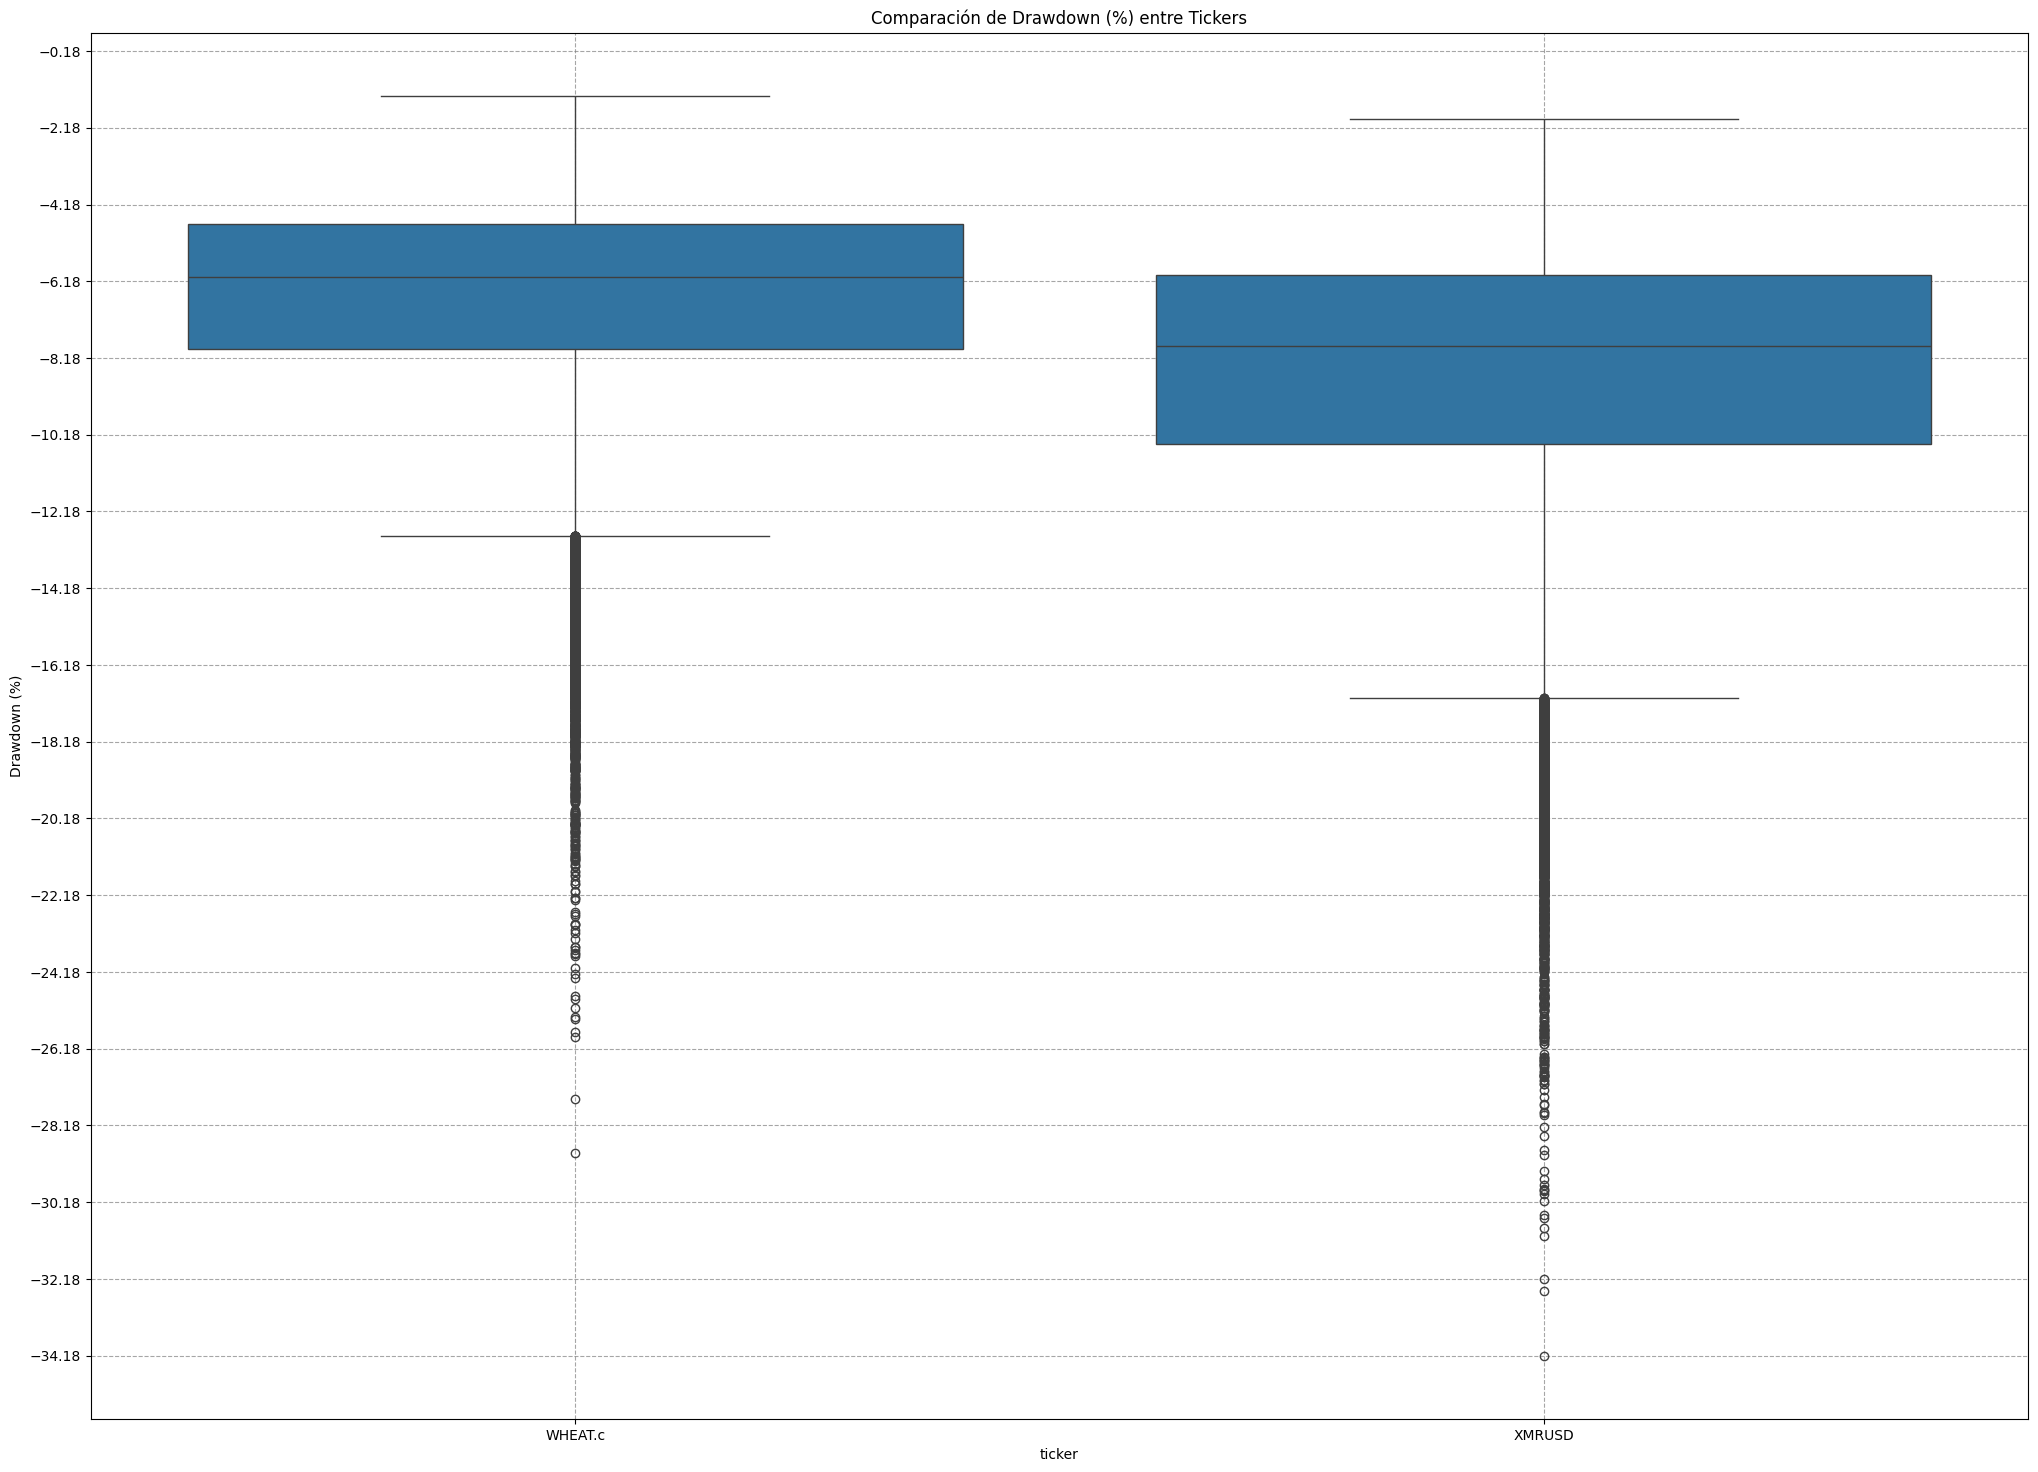

In [39]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(25, 18))
sns.boxplot(data=all_drawdowns, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = all_drawdowns["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = all_drawdowns["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()


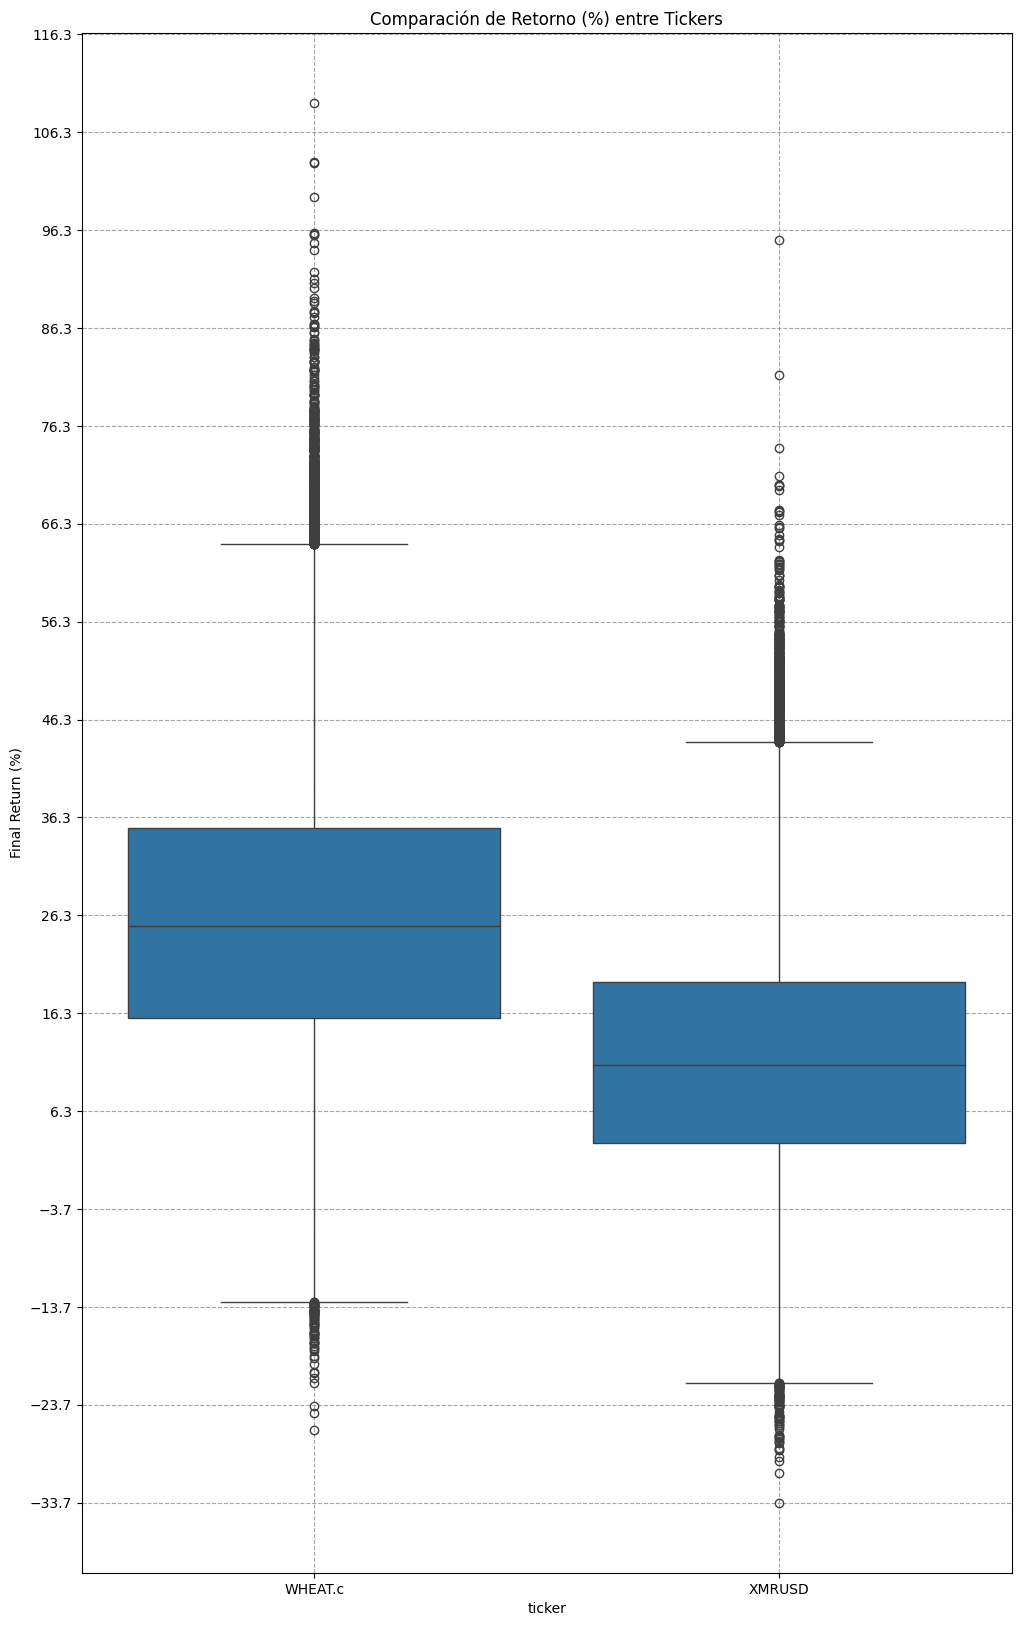

In [40]:
# Generar el gráfico
plt.figure(figsize=(12, 20))
sns.boxplot(data=all_returns, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = all_returns["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = all_returns["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()
